# ShopAssist AI

## Part 1: Introduction

#### **What you have learnt till now**

So far you have learnt how to make LLM API calls in Python. In particular, you worked with OpenAI's GPT 3.5 models and the `Chat Completion API` to build a simple AI tutor.

<br>

Next, you went over some principles, techniques, and tactics for prompt engineering.
The two main principles of writing a good prompt:
1.  Providing clear instructions,
2.  Enhancing LLM reasoning capabilities.

Under providing clear instructions, you learnt how to structure the body of a prompt through 5 components - **Task, Role, Context, Guidelines and Output Format**.

You also understood that providing a very clear syntax and conditioning on good performance can get you closer to the desired output.

<br>

Next, under enhancing LLM reasoning capabilities, you learnt two specific techniques -
(i) Chain-of-Thought prompting,
(ii) Few-Shot prompting.

Under chain-of-thought prompting, you essentially enable the LLM to work through the solution step-by-step and in few-shot prompting, you provide relevant examples of how you want the outputs to look like. So now you could structure your prompts into proper components and provide clear chain-of-thought instructions along with relevant examples of ideal inputs and outputs.

You also learnt some advanced prompting techniques like self-consistency and ReAct prompting. Self-consistency is basically the technique where you ensemble multiple attempts and select the most consistent output out of them. And in ReAct prompting, you enable the LLM to reason out a scenario and act based on some examples.

<br>

Finally, you looked at some examples of how you can design LLM-based systems. Apart from prompting techniques, you understood that designing a LLM-based system also requires a safe design, i.e., the capabilities to detect and respond to unsafe user queries and prompt injections. You looked at the moderation API offered by OpenAI that can help you design such safer systems.

With all of these learnings, let’s now get started on designing our first LLM application - ShopAssist AI.


#### Project Background

In today's digital age, online shopping has become the go-to option for many consumers. However, the overwhelming number of choices and the lack of personalized assistance can make the shopping experience daunting. To address this, we have developed **ShopAssist AI, a chatbot that combines the power of large language models and rule-based functions to ensure accurate and reliable information delivery**.


#### Problem Statement

*Given a dataset containing information about laptops (product names, specifications, descriptions, etc.), build a chatbot that parses the dataset and provides accurate laptop recommendations based on user requirements*.


You can load the data and see it here.

In [ ]:
# Install OpenAI library
!pip install -U -q openai tenacity

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/GenAI Revamp - 2024/GenAI for DS/Live Session Materials')
!ls

In [1]:
# Import the libraries
import pandas as pd
from IPython.display import display, HTML
# Set the display width to control the output width
pd.set_option('display.width', 100)
# Read the dataset and read the Laptop Dataset
df = pd.read_csv('laptop_data.csv')
df.head(5)

,Brand,Model Name,Core,CPU Manufacturer,Clock Speed,RAM Size,Storage Type,Display Type,Display Size,Graphics Processor,Screen Resolution,OS,Laptop Weight,Special Features,Warranty,Average Battery Life,Price,Description
0,Dell,Inspiron,i5,Intel,2.4 GHz,8GB,SSD,LCD,"15.6""",Intel UHD,1920x1080,Windows 10,2.5 kg,Backlit Keyboard,1 year,6 hours,"35,000",The Dell Inspiron is a versatile laptop that c...
1,MSI,GL65,i7,Intel,2.6 GHz,16GB,HDD+SSD,IPS,"15.6""",NVIDIA GTX,1920x1080,Windows 10,2.3 kg,RGB Keyboard,2 years,4 hours,"55,000",The MSI GL65 is a high-performance laptop desi...
2,HP,EliteBook,i7,Intel,2.8 GHz,16GB,SSD,LED,"14""",Intel UHD,1920x1080,Windows 11,1.5 kg,Fingerprint Sensor,3 years,8 hours,"90,000",The HP EliteBook is a premium laptop designed ...
3,Lenovo,IdeaPad,i3,Intel,2.1 GHz,8GB,HDD,TN,"15.6""",Intel UHD,1366x768,Windows 10,2.2 kg,Dolby Audio,1 year,5 hours,"25,000",The Lenovo IdeaPad is a versatile laptop that ...
4,ASUS,ZenBook Pro,i9,Intel,3.1 GHz,64GB,SSD,OLED,"15.6""",NVIDIA RTX,3840x2160,Windows 10,1.8 kg,NanoEdge Display,2 years,7 hours,"200,000",The ASUS ZenBook Pro is a high-end laptop that...


#### Approach:

1. **Conversation and Information Gathering**: The chatbot will utilize language models to understand and generate natural responses. Through a conversational flow, it will ask relevant questions to gather information about the user's requirements.
2. **Information Extraction**: Once the essential information is collected, rule-based functions come into play, extracting top 3 laptops that best matches the user's needs.
3. **Personalized Recommendation**: Leveraging this extracted information, the chatbot engages in further dialogue with the user, efficiently addressing their queries and aiding them in finding the perfect laptop solution.

## Part 2: System Design


#### Dataset

We have a dataset `laptop.csv` where  each row describes the features of a single laptop and also has a small description at the end. The chatbot that we build will leverage LLMs to parse this `Description` column and provide recommendations

#### Workings of the Chatbot

**Note1** - Don't run this when you go through this section for the first time. Run this only after running through the rest of the code. When going through this for the first time, please only go through the output, to understand the workings of the chatbot

**Note2** - The conversation shown here might be different from what you see in the video. However, the overall structure of the conversation to understand the system design remains the same.

In [ ]:
# RUN THIS ONCE ALL THE FUNCTION LAYERS HAVE BEEN DEFINED
dialogue_mgmt_system()

As you could see in the output above, the chatbot should ask a series of questions to
- Determine the user's requirments. For simplicity, we have used 6 features to encapsulate the user's needs. The 6 features are as follows:
    - GPU intensity
    - Display quality
    - Portability
    - Multitasking
    - Processing speed
    - Budget

- Confirm if the user's requirements have been correctly captured at the end.

After that the chatbot lists down the top 3 products that are the most relevant, and engages in further conversation to help the user find the best one.


#### Building the Chatbot

Now let's go ahead and understand the system design for the chatbot.

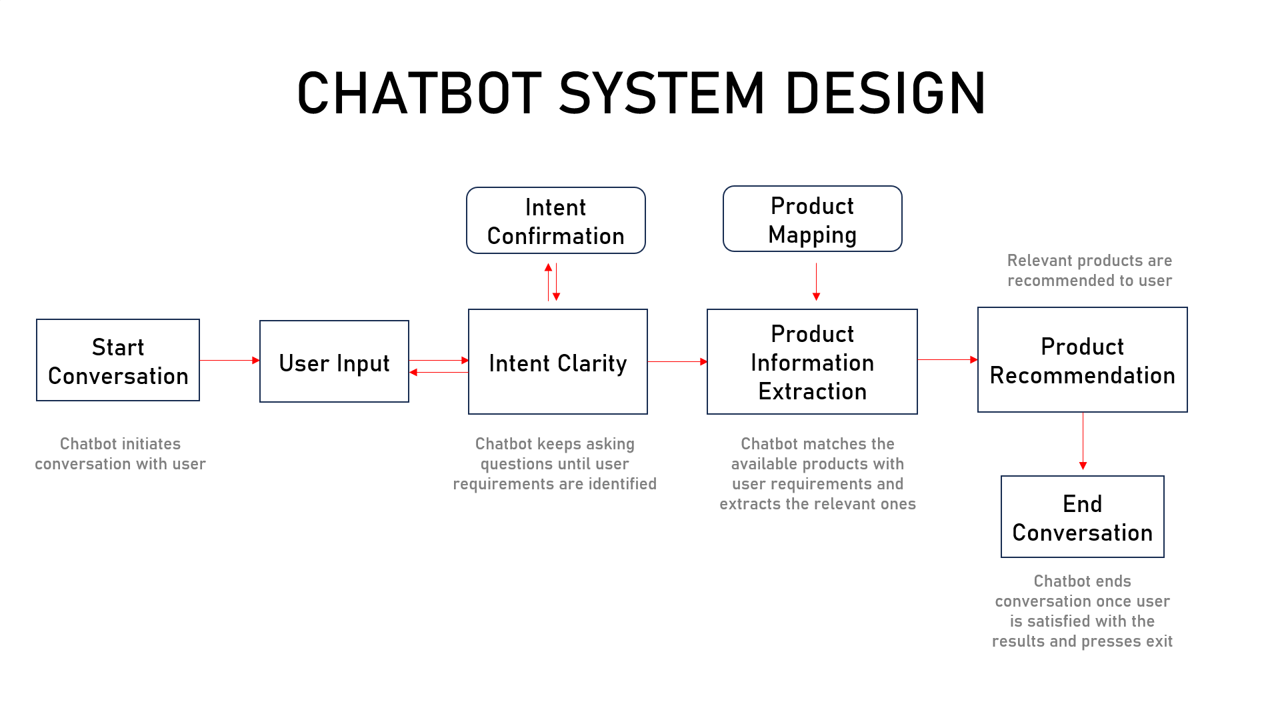

`Stage 1`

- Intent Clarity Layer
- Intent Confirmation Layer

`Stage 2`

- Product Mapping Layer
- Product Information Extraction Layer

`Stage 3`

- Product Recommendation Layer

##### Major functions behind the Chatbot

Let's now look at a brief overview of the major functions that form the chatbot. We'll take a deep dive later



- `initialize_conversation()`: This initializes the variable conversation with the system message.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant
- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not GPU intensity, Display quality, Portability, Multitasking, Processing speed, Budget
- `dictionary_present()`: This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- `compare_laptops_with_user()`: This function compares the user's profile with the different laptops and come back with the top 3 recommendations.
- `initialize_conv_reco()`: Initializes the recommendations conversation

In the next sections, we will look at how to write the code for the above functions.

## Part 3: Implementation

## Stage 1

[Stage 1 Flowchart](https://cdn.upgrad.com/uploads/production/ed8cf454-0c7c-4c5d-bc05-23bb3cea6c57/image+3.jpg)

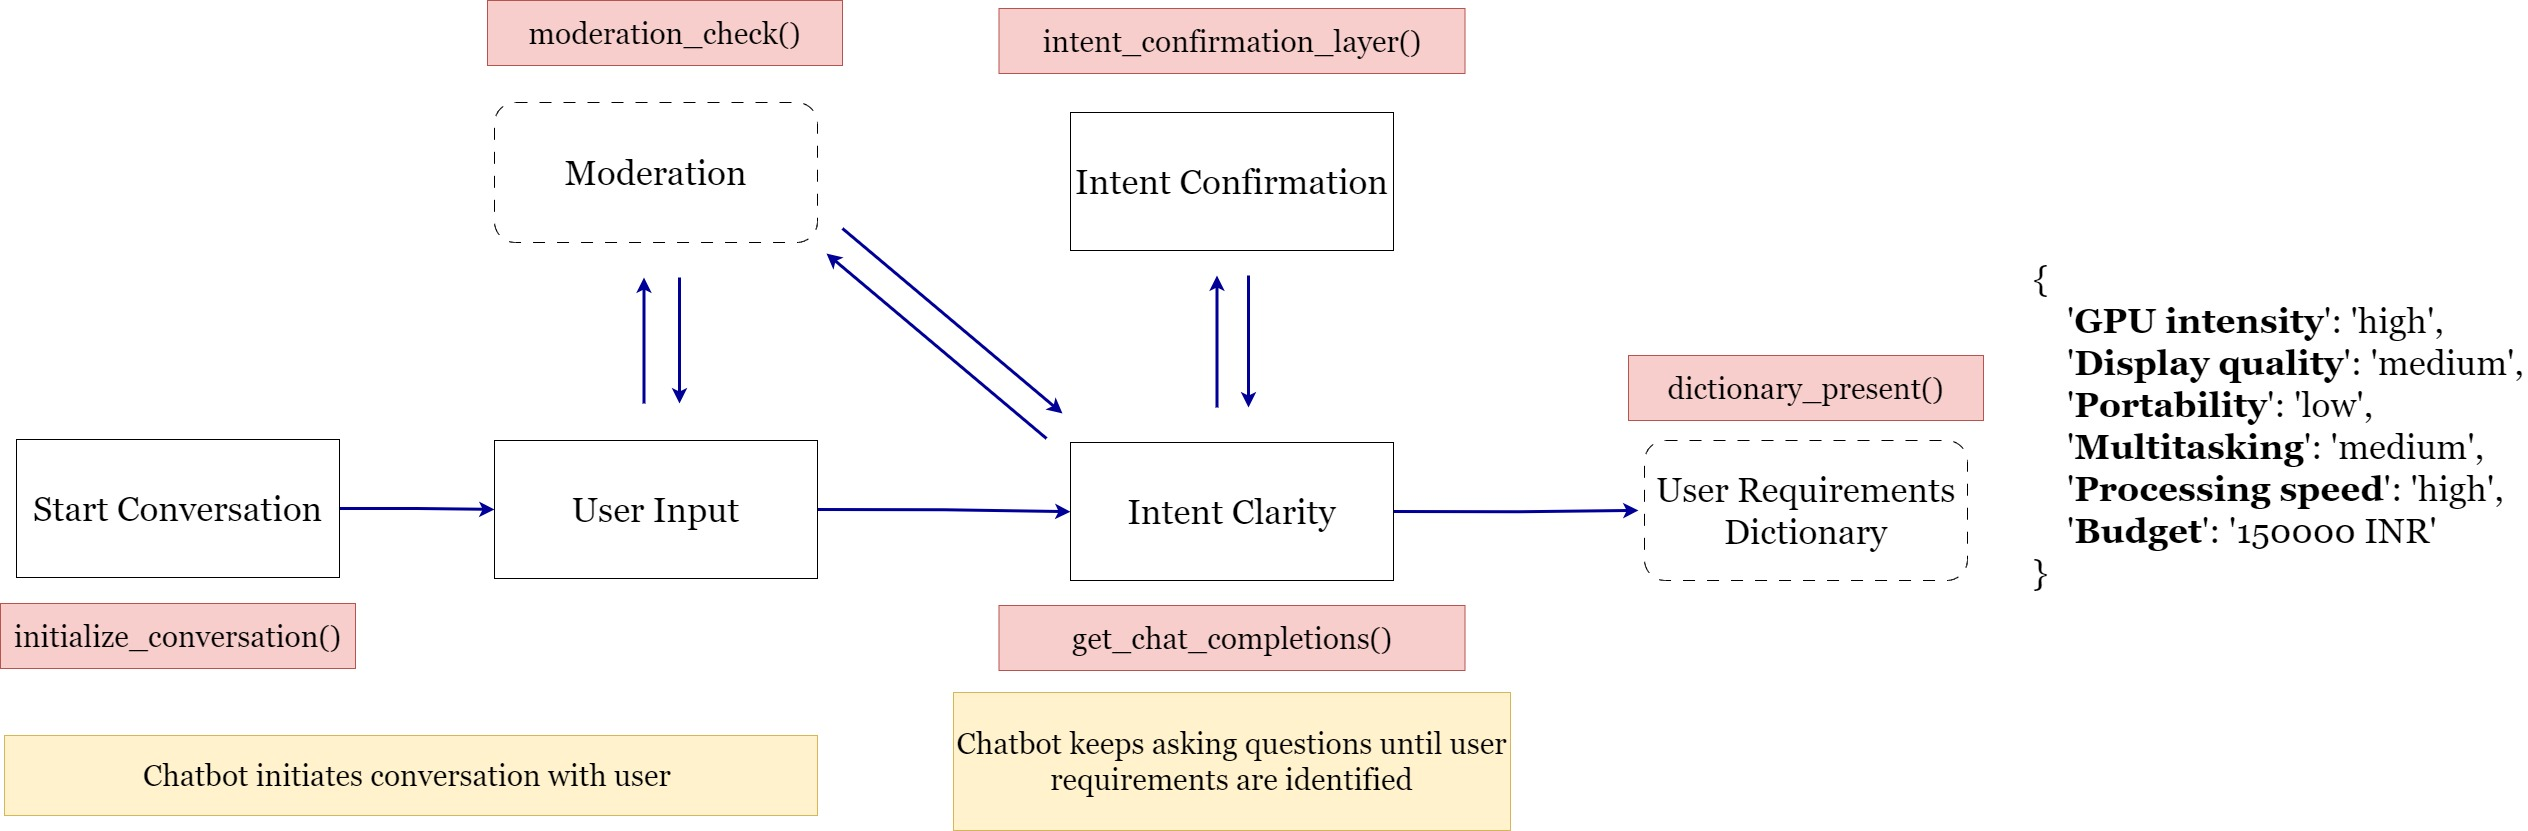

### 3.1 - Import the libraries

Let's start by importing the libraries that we'll require for this project. Following are the ones:
- openai
- pandas
- os, json, ast

Make sure the api key is stored in the text file `OPENAI_API_Key.txt`.

In [2]:
# Import the libraries
import os, json, ast
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

In [3]:
# # If you're using the default OpenAI API key, uncomment the following lines:
openai.api_key = open("OPENAI_API_KEY.txt", "r").read().strip()
os.environ['OPENAI_API_KEY'] = openai.api_key

In [19]:
from config import api_key
openai.api_key = api_key
os.environ['OPENAI_API_KEY'] = api_key # "sk-adfad"

In [4]:
# # Recall that messages to the LLM is a list of dicts containing system_message, user_input and assistant_message
# conversation = [{"role": "system", "content": system_message},
#                 {"role": "user", "content": user_input},
#                 {"role": "assistant", "content": assistant_message}]

### 3.2 - Implementing Intent Clarity and Intent Confirmation Layers

Let's start with the first part of the implementation - building the `intent clarity` and `intent confirmation` layers. As mentioned earlier, this layer helps in identifying the user requirements and passing it on to the product matching layer. Here are the functions that we would be using for building these layers:

- `initialize_conversation()`


### `initialize_conversation()`:
This initializes the variable conversation with the system message. Using prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting(sample conversation between the user and assistant) to align the model about user and assistant responses at each step.



```
def initialize_conversation():
    '''
    Initializes a conversation for an intelligent laptop gadget expert system.

    Returns:
        list: [{"role": "system", "content": system_message}]
        A list containing a dictionary representing the system's initial message.
        
    The function initializes a conversation with the user, providing instructions, examples,
    and a sample conversation to guide the user in interacting with the system. The system's
    initial message includes information about the purpose of the conversation, instructions
    for filling in user profile details, guidelines for asking questions, and a sample
    conversation demonstrating how the interaction with the system progresses.

    The system expects the user to provide information related to their laptop requirements,
    including GPU intensity, display quality, portability, multitasking needs, processing
    speed, and budget. The provided information is used to update a predefined dictionary
    representing the user's profile. The system emphasizes extracting specific details from
    the user's responses to accurately fill in the dictionary values.

    The conversation flow involves three main thoughts:
    - Thought 1: Understanding the user's profile and filling confident values.
    - Thought 2: Filling values for remaining keys based on gathered information.
    - Thought 3: Confirming and verifying updated dictionary values.

    Users are encouraged to engage in a meaningful conversation with the system to ensure
    accurate profile representation and tailored recommendations for the best laptop choice.

    Usage:
        # Initialise the conversation
        conversation = initialize_conversation()
        # Print the conversation
        print(conversation)
    '''
    ```



In [4]:
def initialize_conversation():
    '''
    Returns a list [{"role": "system", "content": system_message}]
    '''

    delimiter = "####"

    example_user_dict = {'GPU intensity': "high",
                        'Display quality':"high",
                        'Portability': "low",
                        'Multitasking': "high",
                        'Processing speed': "high",
                        'Budget': "150000"}

    example_user_req = {'GPU intensity': "_",
                        'Display quality': "_",
                        'Portability': "_",
                        'Multitasking': "_",
                        'Processing speed': "_",
                        'Budget': "_"}

    system_message = f"""
    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.
    You need to ask relevant questions and understand the user profile by analysing the user's responses.
    You final objective is to fill the values for the different keys ('GPU intensity','Display quality','Portability','Multitasking','Processing speed','Budget') in the python dictionary and be confident of the values.
    These key value pairs define the user's profile.
    The python dictionary looks like this
    {{'GPU intensity': 'values','Display quality': 'values','Portability': 'values','Multitasking': 'values','Processing speed': 'values','Budget': 'values'}}
    The value for 'Budget' should be a numerical value extracted from the user's response.
    The values for all keys, except 'Budget', should be 'low', 'medium', or 'high' based on the importance of the corresponding keys, as stated by user.
    All the values in the example dictionary are only representative values.
    {delimiter}
    Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalised:
    - The values for all keys, except 'Budget', should strictly be either 'low', 'medium', or 'high' based on the importance of the corresponding keys, as stated by user.
    - The value for 'Budget' should be a numerical value extracted from the user's response.
    - 'Budget' value needs to be greater than or equal to 25000 INR. If the user says less than that, please mention that there are no laptops in that range.
    - Do not randomly assign values to any of the keys.
    - The values need to be inferred from the user's response.
    {delimiter}

    To fill the dictionary, you need to have the following chain of thoughts:
    Follow the chain-of-thoughts below and only output the final updated python dictionary for the keys as described in {example_user_req}. \n
    {delimiter}
    Thought 1: Ask a question to understand the user's profile and requirements. \n
    If their primary use for the laptop is unclear. Ask followup questions to understand their needs.
    You are trying to fill the values of all the keys {{'GPU intensity','Display quality','Portability','Multitasking','Processing speed','Budget'}} in the python dictionary by understanding the user requirements.
    Identify the keys for which you can fill the values confidently using the understanding. \n
    Remember the instructions around the values for the different keys.
    If the necessary information has been extracted, only then proceed to the next step. \n
    Otherwise, rephrase the question to capture their profile clearly. \n

    {delimiter}
    Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step.
    Remember the instructions around the values for the different keys.
    Ask questions you might have for all the keys to strengthen your understanding of the user's profile.
    If yes, move to the next Thought. If no, ask question on the keys whose values you are unsure of. \n
    It is a good practice to ask question with a sound logic as opposed to directly citing the key you want to understand value for.
    {delimiter}

    {delimiter}
    Thought 3: Check if you have correctly updated the values for the different keys in the python dictionary.
    If you are not confident about any of the values, ask clarifying questions.
    {delimiter}

    {delimiter}
    Here is a sample conversation between the user and assistant:
    User: "Hi, I am an editor."
    Assistant: "Great! As an editor, you likely require a laptop that can handle demanding tasks. Hence, the laptop should have high multitasking capability. You would also need a high end display for better visuals and editing. May I know what kind of work do you primarily focus on? Are you more involved in video editing, photo editing, or both? Understanding the specific type of editing work will help me tailor my recommendations accordingly. Let me know if my understanding is correct until now."
    User: "I primarily work with After Effects."
    Assistant: "Thank you for providing that information. Working with After Effects involves working with graphics, animations, and rendering, which will require high GPU. Do you work with high-resolution media files, such as 4K videos or RAW photos? Understanding your file sizes will help determine the storage capacity and processing power needed."
    User: "Yes, sometimes I work with 4K videos as well."
    Assistant: "Thank you for the information. Processing 4K vidoes will require a good processor and high GPU. I think we have already determined earlier that you need a high GPU. To ensure I have a complete understanding of your needs, I have one more question: Are you frequently on the go and require a laptop that is lightweight and easy to carry, or do you primarily work from a stationary location?"
    User: "Yes, sometimes I travel but do not carry my laptop."
    Assistant:"Could you kindly let me know your budget for the laptop? This will help me find options that fit within your price range while meeting the specified requirements."
    User: "my max budget is 1.5lakh inr"
    Assistant: "{example_user_dict}"
    {delimiter}

    Start with a short welcome message and encourage the user to share their requirements.
    """
    conversation = [{"role": "system", "content": system_message}]
    # conversation = system_message
    return conversation

Let's see what does `initialize_conversation()` does.

<br>

We have added a prefix `debug_` to each of the variables so that we can play around with the inputs and outputs and it doesn't disturb the main function.

In [5]:
debug_conversation = initialize_conversation()
print(debug_conversation)

[{'role': 'system', 'content': '\n    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.\n    You need to ask relevant questions and understand the user profile by analysing the user\'s responses.\n    You final objective is to fill the values for the different keys (\'GPU intensity\',\'Display quality\',\'Portability\',\'Multitasking\',\'Processing speed\',\'Budget\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'GPU intensity\': \'values\',\'Display quality\': \'values\',\'Portability\': \'values\',\'Multitasking\': \'values\',\'Processing speed\': \'values\',\'Budget\': \'values\'}\n    The value for \'Budget\' should be a numerical value extracted from the user\'s response.\n    The values for all keys, except \'Budget\', should be \'low\', \'medium\', or \'high\' based on the importance of the corresponding keys, as stat

In [6]:
# Let's look at the content in the debug_conversation key
print(debug_conversation[0]['content'])


    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.
    You need to ask relevant questions and understand the user profile by analysing the user's responses.
    You final objective is to fill the values for the different keys ('GPU intensity','Display quality','Portability','Multitasking','Processing speed','Budget') in the python dictionary and be confident of the values.
    These key value pairs define the user's profile.
    The python dictionary looks like this
    {'GPU intensity': 'values','Display quality': 'values','Portability': 'values','Multitasking': 'values','Processing speed': 'values','Budget': 'values'}
    The value for 'Budget' should be a numerical value extracted from the user's response.
    The values for all keys, except 'Budget', should be 'low', 'medium', or 'high' based on the importance of the corresponding keys, as stated by user.
    All the values in the example dictionary are only representative values.


Let's now look at the next function.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant. We'll use the Chat Completions function for performing LLM calls to OpenAI.

### `get_chat_completions()`:

This function perform LLM call using the Chat Completions API to get the LLM response.

In [7]:
# Define a Chat Completions API call
# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_chat_completions(input, json_format = False):
    MODEL = 'gpt-3.5-turbo'

    system_message_json_output = """<<. Return output in JSON format to the key output.>>"""

    # If the output is required to be in JSON format
    if json_format == True:
        # Append the input prompt to include JSON response as specified by OpenAI
        input[0]['content'] += system_message_json_output

        # JSON return type specified
        chat_completion_json = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            response_format = { "type": "json_object"},
            seed = 1234)

        output = json.loads(chat_completion_json.choices[0].message.content)

    # No JSON return type specified
    else:
        chat_completion = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            seed = 2345)

        output = chat_completion.choices[0].message.content

    return output

In [9]:
# # Define Completions API call (Legacy)
# # Note that the Completions API is deprecated and we'll be using only the Chat Completions API in this project
# def get_completions(input_prompt):
#   response = openai.completions.create(
#       model="gpt-3.5-turbo-instruct",
#       prompt=input_prompt,
#       temperature=0)
#   return response.choices[0].text

In [8]:
# Testing the OpenAI functions defined above
input_prompt ='What is the capital of France?'
messages = [{'role':'user','content':input_prompt}]
# system_message_json_output = """<<. Return output in JSON format.>>"""
# messages[0]['content']+=system_message_json_output
messages

[{'role': 'user', 'content': 'What is the capital of France?'}]

In [9]:
## Get LLM Outputs - normal
get_chat_completions(messages) ## Chat Completions API

'The capital of France is Paris.'

In [10]:
## Get LLM Outputs - JSON output
get_chat_completions(messages, json_format = True) ## Chat Completions API and return in JSON format

{'output': 'Paris'}

### iterate_response() - Helper Function:
We've created a small helper test function to ensure the model's response is consistent.
Uncomment the code blocks and run the function `iterate_response(response)` to check if the response of the `intent_confirmation_layer`is consistent.}

In [11]:
def iterate_llm_response(funct, debug_response, num = 10):
    """
    Calls a specified function repeatedly and prints the results.
    This function is designed to test the consistency of a response from a given function.
    It calls the function multiple times (default is 10) and prints out the iteration count,
    the function's response(s).
    Args:
        funct (function): The function to be tested. This function should accept a single argument
                          and return the response value(s).
        debug_response (dict): The input argument to be passed to 'funct' on each call.
        num (int, optional): The number of times 'funct' will be called. Defaults to 10.
    Returns:
        This function only returns the results to the console.
    """
    i = 0  # Initialize counter

    while i < num:  # Loop to call the function 'num' times

        response = funct(debug_response)  # Call the function with the debug response

        # Print the iteration number, result, and reason from the response
        print("Iteration: {0}".format(i))
        print(response)
        print('-' * 50)  # Print a separator line for readability
        i += 1  # Increment the counter

# Example usage: test the consistency of responses from 'intent_confirmation_layer'
# iterate_llm_response(get_chat_completions, messages)

Let's pass the initialized conversation `debug_conversation` and see what is the assistant's response.

In [12]:
debug_user_input = "Hi, I am Anavit. I need a laptop for coding."

In [13]:
debug_conversation.append({"role": "user", "content": debug_user_input})
# print(debug_conversation[0]["content"]) # System Message
print(debug_conversation[1]["content"]) # User Input

Hi, I am Anavit. I need a laptop for coding.


In [14]:
# Let's look at the debug_conversation list
display(debug_conversation)

[{'role': 'system',
  'content': '\n    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.\n    You need to ask relevant questions and understand the user profile by analysing the user\'s responses.\n    You final objective is to fill the values for the different keys (\'GPU intensity\',\'Display quality\',\'Portability\',\'Multitasking\',\'Processing speed\',\'Budget\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'GPU intensity\': \'values\',\'Display quality\': \'values\',\'Portability\': \'values\',\'Multitasking\': \'values\',\'Processing speed\': \'values\',\'Budget\': \'values\'}\n    The value for \'Budget\' should be a numerical value extracted from the user\'s response.\n    The values for all keys, except \'Budget\', should be \'low\', \'medium\', or \'high\' based on the importance of the corresponding keys, as st

In [15]:
# Getting the response from the Assistant by passing the conversation to the Chat Completions API
debug_response_assistant = get_chat_completions(debug_conversation)
display(debug_response_assistant)

'Great! As a coder, you likely require a laptop that can handle multitasking efficiently and has good processing speed. This is important for running multiple code editors, compilers, and virtual machines smoothly. Do you also prioritize display quality for better readability of your code or GPU intensity for any specific tasks like machine learning or gaming? Understanding these aspects will help in finding the right laptop for your coding needs. Can you provide more information on your preferences or specific requirements for a laptop used primarily for coding?'

Let's play around a bit and add the following user's input `debug_user_input` to the conversation `debug_conversation` and see what the assistant responds with.

In [16]:
# Let's append this to the conversation list
debug_conversation.append(({"role": "assistant", "content": debug_response_assistant}))
debug_conversation

[{'role': 'system',
  'content': '\n    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.\n    You need to ask relevant questions and understand the user profile by analysing the user\'s responses.\n    You final objective is to fill the values for the different keys (\'GPU intensity\',\'Display quality\',\'Portability\',\'Multitasking\',\'Processing speed\',\'Budget\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'GPU intensity\': \'values\',\'Display quality\': \'values\',\'Portability\': \'values\',\'Multitasking\': \'values\',\'Processing speed\': \'values\',\'Budget\': \'values\'}\n    The value for \'Budget\' should be a numerical value extracted from the user\'s response.\n    The values for all keys, except \'Budget\', should be \'low\', \'medium\', or \'high\' based on the importance of the corresponding keys, as st

Typically, whenever the chatbot is interacting with the user, all the conversations should be moderated to identify any inappropriate content. Let's look at the function that can help with it.

### `moderation_check()`:
 This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, you can add a break statement to end the conversation.

In [17]:
# Define a function called moderation_check that takes user_input as a parameter.

def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = openai.moderations.create(input=user_input)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

In [18]:
moderation_check("I want to kill them.")

'Flagged'

In [19]:
moderation_check("Hi how are you? I am good ")

'Not Flagged'

In [20]:
moderation_check(" how many people were killed due to covid 19")

'Not Flagged'

Let's test moderation on the `debug_user_input`

In [21]:
debug_moderation = moderation_check(debug_user_input)
print(debug_moderation)

Not Flagged


Let's now test moderation on some other text.

So, this moderation api may not be perfect but if you ask this to the ChatGPT or it's API (GPT 3.5), it'll not help you with such requests. Remember, moderation should also be applied on the GPT 3.5's output.

Let's now check moderation on the assistant's response `debug_response_assistant`.

In [22]:
moderation_check(debug_response_assistant)

'Not Flagged'

As mentioned earlier, you need to understand the user's profile, which essentially means that all the features: GPU intensity, Display quality, Portability, Multitasking, Processing speed, Budget are captured or not. Let's look at the function that helps us verify that.

### `intent_confirmation_layer()`:

This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not
   - GPU intensity
   - Display quality
   - Portability
   - Multitasking
   - Processing speed
   - Budget



```
def intent_confirmation_layer(response_assistant):
    """
    This function serves as an intent confirmation layer for a laptop recommendation system using OpenAI LLM API.

    Parameters:
    - response_assistant (str): The input text containing user requirements captured through 6 keys:
        'GPU intensity', 'Display quality', 'Portability', 'Multitasking', 'Processing speed', and 'Budget'.

    Returns:
    - str: A one-word string in JSON format indicating if the values for the specified keys are correctly filled.
        - 'Yes' if the values are correctly filled for all keys ('GPU intensity', 'Display quality', 'Portability',
          'Multitasking', 'Processing speed') based on the importance as stated by the user.
        - 'No' otherwise.

    Note:
    - The values for all keys, except 'Budget', should be 'low', 'medium', or 'high' based on their importance as stated by the user.
    - The input text should be structured such that it contains the necessary keys and their corresponding values.
    - The function uses OpenAI's Chat Completion API to evaluate the correctness of the input values.
    """
```



In [23]:
def intent_confirmation_layer(response_assistant):

    delimiter = "####"

    allowed_values = {'low','medium','high'}

    prompt = f"""
    You are a senior evaluator who has an eye for detail.The input text will contain a user requirement captured through 6 keys.
    You are provided an input. You need to evaluate if the input text has the following keys:
    {{
    'GPU intensity': 'values',
    'Display quality':'values',
    'Portability':'values',
    'Multitasking':'values',
    'Processing speed':'values',
    'Budget':'number'
    }}
    The values for the keys should only be from the allowed values: {allowed_values}.
    The 'Budget' key can take only a numerical value.
    Next you need to evaluate if the keys have the the values filled correctly.
    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Thought 1 - Output a string 'Yes' if the values are correctly filled for all keys, otherwise output 'No'.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'.
    THought 3 - Think carefully before the answering.
    """

    messages=[{"role": "system", "content":prompt },
              {"role": "user", "content":f"""Here is the input: {response_assistant}""" }]

    response = openai.chat.completions.create(
                                    model="gpt-3.5-turbo",
                                    messages = messages,
                                    response_format={ "type": "json_object" },
                                    seed = 1234
                                    # n = 5
                                    )

    json_output = json.loads(response.choices[0].message.content)

    return json_output

In [27]:
# Here are some sample input output pairs for better understanding:
# {delimiter}
# input: "{{'GPU intensity': 'low', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'low'}}"
# output: No

# input: "{{'GPU intensity': 'low', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': '', 'Budget': '90000'}}"
# output: No

# input: "Here is your user profile 'GPU intensity': 'high','Display quality': 'high','Portability': 'medium','Multitasking': 'low','Processing speed': 'high','Budget': '200000'"
# output: Yes

# input: "Here is your recommendation {{'GPU intensity': 'low', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'low', 'Budget': '90000'}}"
# output: Yes

# input: "Here is your recommendation - 'GPU intensity': 'high' - 'Display quality': 'low' - 'Portability': 'low'  - 'Multitasking': 'high' - 'Processing speed': 'high' - 'Budget': '90000' "
# output: Yes

# input: "You can look at this - GPU intensity: high - Display quality: low - Portability: low  - Multitasking: high - Processing speed: high - Budget: 90000"
# output: Yes

# input: "{{GPU intensity: low, Display quality: high, Portability: low, Multitasking:high,Processing speed: Low, Budget: 70000}}"
# output: No

# {delimiter}

Let's apply the function to the assistant's reponse and see if it has captured the user profile.

In [24]:
debug_response_assistant

'Great! As a coder, you likely require a laptop that can handle multitasking efficiently and has good processing speed. This is important for running multiple code editors, compilers, and virtual machines smoothly. Do you also prioritize display quality for better readability of your code or GPU intensity for any specific tasks like machine learning or gaming? Understanding these aspects will help in finding the right laptop for your coding needs. Can you provide more information on your preferences or specific requirements for a laptop used primarily for coding?'

In [25]:
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
display(debug_confirmation)

{'result': 'No',
 'reason': "Missing required keys: 'GPU intensity', 'Display quality', 'Portability', 'Budget'"}

In [26]:
# Printing the value for better clarity
print("Result:",debug_confirmation.get('result'),"\t", "Reason:", debug_confirmation.get('reason'))

Result: No 	 Reason: Missing required keys: 'GPU intensity', 'Display quality', 'Portability', 'Budget'


Now, you can keep adding user and assistant responses to debug_conversation and get to a point where intent_confirmation_layer() gives yes as a response. Let's see if the following response by the assistant passes the intent_confirmation_layer() test.

In [27]:
#Let's add the above assistant response to the debug_conversation.
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})

In [28]:
debug_conversation

[{'role': 'system',
  'content': '\n    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.\n    You need to ask relevant questions and understand the user profile by analysing the user\'s responses.\n    You final objective is to fill the values for the different keys (\'GPU intensity\',\'Display quality\',\'Portability\',\'Multitasking\',\'Processing speed\',\'Budget\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'GPU intensity\': \'values\',\'Display quality\': \'values\',\'Portability\': \'values\',\'Multitasking\': \'values\',\'Processing speed\': \'values\',\'Budget\': \'values\'}\n    The value for \'Budget\' should be a numerical value extracted from the user\'s response.\n    The values for all keys, except \'Budget\', should be \'low\', \'medium\', or \'high\' based on the importance of the corresponding keys, as st

Let's say that after a series of conversations you get the following response from the assistant.

In [29]:
# Example 1 - Let's check with the confirmation_layer if all the keys are present
debug_response_assistant_1 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{{'GPU intensity':'high',
 'Display quality':'high',
 'Portability':'low',
 'Multitasking':'low',
 'Processing speed':'low',
 'Budget':'50000 INR'}}
"""
#Note that you are using double curly braces

print(debug_response_assistant_1)


Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{'GPU intensity':'high',
 'Display quality':'high',
 'Portability':'low',
 'Multitasking':'low',
 'Processing speed':'low',
 'Budget':'50000 INR'}



Do you think it'll pass the `intent_confirmation_layer()` test?

 Let's try it out.

In [30]:
response = intent_confirmation_layer(debug_response_assistant_1)
print(response)
response.get('result') # Extract the result key from the dictionary

{'result': 'Yes'}


'Yes'

In [31]:
# Example 2 - Let's check confirmation_layer if all the keys are present
debug_response_assistant_2 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{{'GPU intensity':'high',
 'Display quality':'high',
 'Portability':'low',
 'Multitasking':'low',
 'Processing speed':'low'}}
"""
#Note that you are using double curly braces

print(debug_response_assistant_2)


Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{'GPU intensity':'high',
 'Display quality':'high',
 'Portability':'low',
 'Multitasking':'low',
 'Processing speed':'low'}



In [32]:
intent_confirmation_layer(debug_response_assistant_2)
# iterate_llm_response(intent_confirmation_layer, debug_response_assistant_2)

{'result': 'No', 'reason': 'Budget key is missing.'}

In [33]:
# Example 3 - Let's check confirmation_layer if all the keys are present
debug_response_assistant_3 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{{'GPU intensity':'high',
 'Display quality':'high',
 'Portability':'low',
 'Multitasking':'low',
 'Processing speed':'low',
 'Budget':'50000'}}
"""
#Note that you are using double curly braces

print(debug_response_assistant_3)


Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{'GPU intensity':'high',
 'Display quality':'high',
 'Portability':'low',
 'Multitasking':'low',
 'Processing speed':'low',
 'Budget':'50000'}



In [34]:
intent_confirmation_layer(debug_response_assistant_3)
# iterate_llm_response(intent_confirmation_layer, debug_response_assistant_3)

{'result': 'Yes'}

Let's now look at the working of `dictionary_present()`.

### `dictionary_present()`:

This function checks if the final understanding of user's profile is returned by the chatbot is a Python dictionary or not. This is important as it'll be used later on for finding the right laptops using dictionary matching.

In [35]:
def dictionary_present(response):
    delimiter = "####"

    user_req = {'GPU intensity': 'high',
                'Display quality': 'high',
                'Portability': 'medium',
                'Multitasking': 'high',
                'Processing speed': 'high',
                'Budget': '200000'}

    prompt = f"""You are a python expert. You are provided an input.
            You have to check if there is a python dictionary present in the string.
            It will have the following format {user_req}.
            Your task is to just extract the relevant values from the input and return only the python dictionary in JSON format.
            The output should match the format as {user_req}.

            {delimiter}
            Make sure that the value of budget is also present in the user input. ###
            The output should contain the exact keys and values as present in the input.
            Ensure the keys and values are in the given format:
            {{
            'GPU intensity': 'low/medium/high ',
            'Display quality':'low/medium/high',
            'Portability':'low/medium/high',
            'Multitasking':'low/medium/high',
            'Processing speed':'low/medium/high',
            'Budget':'numerical value'
            }}
            Here are some sample input output pairs for better understanding:
            {delimiter}
            input 1: - GPU intensity: low - Display quality: high - Portability: low - Multitasking: high - Processing speed: medium - Budget: 50,000 INR
            output 1: {{'GPU intensity': 'low', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'medium', 'Budget': '50000'}}

            input 2: {{'GPU intensity':     'low', 'Display quality':     'low', 'Portability':    'medium', 'Multitasking': 'medium', 'Processing speed': 'low', 'Budget': '90,000'}}
            output 2: {{'GPU intensity': 'low', 'Display quality': 'low', 'Portability': 'medium', 'Multitasking': 'medium', 'Processing speed': 'low', 'Budget': '90000'}}

            input 3: Here is your user profile 'GPU intensity': 'high','Display quality': 'high','Portability': 'medium','Multitasking': 'high','Processing speed': 'high','Budget': '200000 INR'
            output 3: {{'GPU intensity': 'high','Display quality': 'high','Portability': 'medium','Multitasking': 'high','Processing speed': 'high','Budget': '200000'}}
            {delimiter}
            """
    messages = [{"role": "system", "content":prompt },
                {"role": "user", "content":f"""Here is the user input: {response}""" }]

    confirmation = get_chat_completions(messages, json_format = True)

    return confirmation

Let's start by passing the `debug_response_assistant`.

In [36]:
debug_response_assistant_n = """
{'GPU intensity':'high',
 'Display quality':'high',
 'Portability':'low',
 'Multitasking':'low',
 'Processing speed':'low',
 'Budget':'50000'}
"""

In [37]:
response_dict_n = dictionary_present(debug_response_assistant_n)
display(response_dict_n)

{'GPU intensity': 'high',
 'Display quality': 'high',
 'Portability': 'low',
 'Multitasking': 'low',
 'Processing speed': 'low',
 'Budget': '50000'}

In [38]:
type(response_dict_n)

dict

What if you pass something like this where it is not in the form of a dictionary? Or some key or some values are missing? Let's see.

In [51]:
debug_response_assistant_n = f"""Thank you for providing your budget.
Based on your budget of 50,000 INR, I will consider this while recommending suitable laptop options for you.
Here is the final recommendation for your laptop:
- GPU intensity: high
- Display quality: high
- Portability: low
- Multitasking: high
- Processing speed: medium
- Budget: 80,000 INR

Please note that these specifications are based on your requirements for surfing and a decent display within your budget.
Let me know if there's anything else I can assist you with!"""

In [52]:
response_dict_n = dictionary_present(debug_response_assistant_n)
display(response_dict_n)

{'GPU intensity': 'high',
 'Display quality': 'high',
 'Portability': 'low',
 'Multitasking': 'high',
 'Processing speed': 'medium',
 'Budget': '80000'}

In [53]:
type(response_dict_n)

dict

In [54]:
# Check for LLM function's consistency
iterate_llm_response(dictionary_present, debug_response_assistant_n)

Iteration: 0
{'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'medium', 'Budget': '80000'}
--------------------------------------------------
Iteration: 1
{'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'medium', 'Budget': '80000'}
--------------------------------------------------
Iteration: 2
{'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'medium', 'Budget': '80000'}
--------------------------------------------------
Iteration: 3
{'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'medium', 'Budget': '80000'}
--------------------------------------------------
Iteration: 4
{'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'medium', 'Budget': 

Let's quickly take a look at the code that we have run until now.

In [86]:
debug_conversation

[{'role': 'system',
  'content': '\n    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.\n    You need to ask relevant questions and understand the user profile by analysing the user\'s responses.\n    You final objective is to fill the values for the different keys (\'GPU intensity\',\'Display quality\',\'Portability\',\'Multitasking\',\'Processing speed\',\'Budget\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'GPU intensity\': \'values\',\'Display quality\': \'values\',\'Portability\': \'values\',\'Multitasking\': \'values\',\'Processing speed\': \'values\',\'Budget\': \'values\'}\n    The value for \'Budget\' should be a numerical value extracted from the user\'s response.\n    The values for all keys, except \'Budget\', should be \'low\', \'medium\', or \'high\' based on the importance of the corresponding keys, as st

In [46]:
debug_conversation = initialize_conversation()
debug_user_input = "Hi, I am Anand. I need a laptop for coding."
debug_moderation = moderation_check(debug_user_input)
debug_conversation.append({"role": "user", "content": debug_user_input})
debug_response_assistant = get_chat_completions(debug_conversation)
debug_moderation = moderation_check(debug_response_assistant)
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
# print(debug_confirmation)
# After a series of conversation...
response_dict_n = dictionary_present(debug_response_assistant_n)
print(response_dict_n)

{'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'medium', 'Budget': '80000'}


So, now that you have the user profile stored in `response_dict_n`. We'll use this to generate recommendations. Before that, we need to create a similar profile for every laptop. Let's see how we do it.

## Stage 2

[Stage 2 Flowchart](https://cdn.upgrad.com/uploads/production/c71aa254-32db-4265-a083-f4a540dac014/Stage+2.jpg)

### 3.3 Implementing the Product Mapping and Information Extraction Layers

In this section, we take in the output of the previous layers, i.e. the user requirements, which is in the format of a Python dictionary.
<br>
Next we will extract the top 3 laptop recommendations based on user's requirements.

This stage consists of the following helper functions that will implement the information extraction and product matching layers.

### `product_map_layer()`:

This function is responsible for extracting key features and criteria from laptop descriptions. Here's a breakdown of how it works:

-  Use a prompt that assign it the role of a Laptop Specifications Classifier, whose objective is to extract key features and classify them based on laptop descriptions.

- Provide step-by-step instructions for extracting laptop features from description.

- Assign specific rules for each feature (e.g., GPU Intensity, Display Quality, Portability, Multitasking, Processing Speed) and associate them with the appropriate classification value (Low, Medium, or High).

- Includes Few Shot Prompting (sample conversation between the user and assistant) to demonstrate the expected result of the feature extraction and classification process.

In [55]:
def product_map_layer(laptop_description):
    delimiter = "#####"

    lap_spec = {
        "GPU intensity":"(Type of the Graphics Processor)",
        "Display quality":"(Display Type, Screen Resolution, Display Size)",
        "Portability":"(Laptop Weight)",
        "Multitasking":"(RAM Size)",
        "Processing speed":"(CPU Type, Core, Clock Speed)"
    }

    values = {'low','medium','high'}

    prompt=f"""
    You are a Laptop Specifications Classifier whose job is to extract the key features of laptops and classify them as per their requirements.
    To analyze each laptop, perform the following steps:
    Step 1: Extract the laptop's primary features from the description {laptop_description}
    Step 2: Store the extracted features in {lap_spec} \
    Step 3: Classify each of the items in {lap_spec} into {values} based on the following rules: \
    {delimiter}
    GPU Intensity:
    - low: <<< if GPU is entry-level such as an integrated graphics processor or entry-level dedicated graphics like Intel UHD >>> , \n
    - medium: <<< if mid-range dedicated graphics like M1, AMD Radeon, Intel Iris >>> , \n
    - high: <<< high-end dedicated graphics like Nvidia RTX >>> , \n

    Display Quality:
    - low: <<< if resolution is below Full HD (e.g., 1366x768). >>> , \n
    - medium: <<< if Full HD resolution (1920x1080) or higher. >>> , \n
    - high: <<< if High-resolution display (e.g., 4K, Retina) with excellent color accuracy and features like HDR support. >>> \n

    Portability:
    - high: <<< if laptop weight is less than 1.51 kg >>> , \n
    - medium: <<< if laptop weight is between 1.51 kg and 2.51 kg >>> , \n
    - low: <<< if laptop weight is greater than 2.51 kg >>> \n

    Multitasking:
    - low: <<< If RAM size is 8 GB, 12 GB >>> , \n
    - medium: <<< if RAM size is 16 GB >>> , \n
    - high: <<< if RAM size is 32 GB, 64 GB >>> \n

    Processing Speed:
    - low: <<< if entry-level processors like Intel Core i3, AMD Ryzen 3 >>> , \n
    - medium: <<< if Mid-range processors like Intel Core i5, AMD Ryzen 5 >>> , \n
    - high: <<< if High-performance processors like Intel Core i7, AMD Ryzen 7 or higher >>> \n
    {delimiter}

    {delimiter}
    Here is input output pair for few-shot learning:
    input 1: "The Dell Inspiron is a versatile laptop that combines powerful performance and affordability. It features an Intel Core i5 processor clocked at 2.4 GHz, ensuring smooth multitasking and efficient computing. With 8GB of RAM and an SSD, it offers quick data access and ample storage capacity. The laptop sports a vibrant 15.6" LCD display with a resolution of 1920x1080, delivering crisp visuals and immersive viewing experience. Weighing just 2.5 kg, it is highly portable, making it ideal for on-the-go usage. Additionally, it boasts an Intel UHD GPU for decent graphical performance and a backlit keyboard for enhanced typing convenience. With a one-year warranty and a battery life of up to 6 hours, the Dell Inspiron is a reliable companion for work or entertainment. All these features are packed at an affordable price of 35,000, making it an excellent choice for budget-conscious users."
    output 1: {{'GPU intensity': 'medium','Display quality':'medium','Portability':'medium','Multitasking':'high','Processing speed':'medium'}}

    {delimiter}
    ### Strictly don't keep any other text in the values of the JSON dictionary other than low or medium or high ###
    """
    input = f"""Follow the above instructions step-by-step and output the dictionary in JSON format {lap_spec} for the following laptop {laptop_description}."""
    #see that we are using the Completion endpoint and not the Chatcompletion endpoint
    messages=[{"role": "system", "content":prompt },{"role": "user","content":input}]

    response = get_chat_completions(messages, json_format = True)

    #   response = openai.chat.completions.create(
    #     model="gpt-3.5-turbo-0125",
    #     messages=[{"role": "system", "content":prompt },{"role": "user","content":input}],
    #     response_format={ "type": "json_object" }
    #     # max_tokens = 2000,
    #     )

    # response = json.loads(response)
    return response

Let's test this for one sample laptop description.

In [56]:
laptop_description_1 = f"""
The Dell Inspiron is a versatile laptop that combines powerful performance and affordability.
It features an Intel Core i5 processor clocked at 2.4 GHz, ensuring smooth multitasking and efficient computing.
With 8GB of RAM and an SSD, it offers quick data access and ample storage capacity.
The laptop sports a vibrant 15.6" LCD display with a resolution of 1920x1080, delivering crisp visuals and immersive viewing experience.
Weighing just 2.5 kg, it is highly portable, making it ideal for on-the-go usage.
Additionally, it boasts an Intel UHD GPU for decent graphical performance and a backlit keyboard for enhanced typing convenience.
With a one-year warranty and a battery life of up to 6 hours, the Dell Inspiron is a reliable companion for work or entertainment.
All these features are packed at an affordable price of 35,000, making it an excellent choice for budget-conscious users.
"""

In [57]:
display(product_map_layer(laptop_description_1))

{'GPU intensity': 'medium',
 'Display quality': 'medium',
 'Portability': 'medium',
 'Multitasking': 'high',
 'Processing speed': 'medium'}

In [128]:
# # Data type of the output response
print(type(product_map_layer(laptop_description_1)))

<class 'dict'>


In [58]:
# # Check for consistency with iterate_response function
iterate_llm_response(product_map_layer, laptop_description_1)

Iteration: 0
{'GPU intensity': 'medium', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'high', 'Processing speed': 'medium'}
--------------------------------------------------
Iteration: 1
{'GPU intensity': 'medium', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'high', 'Processing speed': 'medium'}
--------------------------------------------------
Iteration: 2
{'GPU intensity': 'medium', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'high', 'Processing speed': 'medium'}
--------------------------------------------------
Iteration: 3
{'GPU intensity': 'medium', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'high', 'Processing speed': 'medium'}
--------------------------------------------------
Iteration: 4
{'GPU intensity': 'medium', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'high', 'Processing speed': 'medium'}
--------------------------------------------------


Let's now apply this function to the entire laptop dataset

In [59]:
laptop_df= pd.read_csv('laptop_data.csv')
laptop_df["Description"][0]

'The Dell Inspiron is a versatile laptop that combines powerful performance and affordability. It features an Intel Core i5 processor clocked at 2.4 GHz, ensuring smooth multitasking and efficient computing. With 8GB of RAM and an SSD, it offers quick data access and ample storage capacity. The laptop sports a vibrant 15.6" LCD display with a resolution of 1920x1080, delivering crisp visuals and immersive viewing experience. Weighing just 2.5 kg, it is highly portable, making it ideal for on-the-go usage. Additionally, it boasts an Intel UHD GPU for decent graphical performance and a backlit keyboard for enhanced typing convenience. With a one-year warranty and a battery life of up to 6 hours, the Dell Inspiron is a reliable companion for work or entertainment. All these features are packed at an affordable price of 35,000, making it an excellent choice for budget-conscious users.'

In [60]:
product_map_layer(laptop_df["Description"][0])

{'GPU intensity': 'medium',
 'Display quality': 'medium',
 'Portability': 'medium',
 'Multitasking': 'high',
 'Processing speed': 'medium'}

In [54]:
laptop_df.head(1)

,Brand,Model Name,Core,CPU Manufacturer,Clock Speed,RAM Size,Storage Type,Display Type,Display Size,Graphics Processor,Screen Resolution,OS,Laptop Weight,Special Features,Warranty,Average Battery Life,Price,Description
0,Dell,Inspiron,i5,Intel,2.4 GHz,8GB,SSD,LCD,"15.6""",Intel UHD,1920x1080,Windows 10,2.5 kg,Backlit Keyboard,1 year,6 hours,"35,000",The Dell Inspiron is a versatile laptop that c...


In [61]:
##Run this code once to extract product info in the form of a dictionary
# laptop_df= pd.read_csv('laptop_data.csv')

## Create a new column "laptop_feature" that contains the dictionary of the product features
laptop_df['laptop_feature'] = laptop_df['Description'].apply(lambda x: product_map_layer(x))

In [62]:
laptop_df.head(2)

,Brand,Model Name,Core,CPU Manufacturer,Clock Speed,RAM Size,Storage Type,Display Type,Display Size,Graphics Processor,Screen Resolution,OS,Laptop Weight,Special Features,Warranty,Average Battery Life,Price,Description,laptop_feature
0,Dell,Inspiron,i5,Intel,2.4 GHz,8GB,SSD,LCD,"15.6""",Intel UHD,1920x1080,Windows 10,2.5 kg,Backlit Keyboard,1 year,6 hours,"35,000",The Dell Inspiron is a versatile laptop that c...,"{'GPU intensity': 'medium', 'Display quality':..."
1,MSI,GL65,i7,Intel,2.6 GHz,16GB,HDD+SSD,IPS,"15.6""",NVIDIA GTX,1920x1080,Windows 10,2.3 kg,RGB Keyboard,2 years,4 hours,"55,000",The MSI GL65 is a high-performance laptop desi...,"{'GPU intensity': 'high', 'Display quality': '..."


In [63]:
laptop_df["laptop_feature"][0]

{'GPU intensity': 'medium',
 'Display quality': 'medium',
 'Portability': 'medium',
 'Multitasking': 'high',
 'Processing speed': 'medium'}

In [141]:
laptop_df.to_csv("updated_laptop.csv",index=False,header = True)

### `compare_laptops_with_user()`:

This function compares the user's profile with the different laptops and come back with the top  recommendations. It will perform the following steps:
    - It will take the user requirements dictionary as input
    - Filter the laptops based on their price, keeping only the ones within the user's budget.
    - Calculate a score for each laptop based on how well it matches the user's requirements.
    - Sort the laptops based on their scores in descending order.
    - Return the top 3 laptops as a JSON-formatted string.

In [64]:
dict1 = {'GPU intensity': 'medium', 
         'Display quality': 'medium', 
         'Portability': 'medium', 
         'Multitasking': 'high', 
         'Processing speed': 'LOWMedium'}
mappings = {'low': 0, 'medium': 1, 'high': 2}
for key, value in dict1.items():
    print("Key: ",key, " Values: ",value, "Mapping: ",mappings.get(value,-1))

Key:  GPU intensity  Values:  medium Mapping:  1
Key:  Display quality  Values:  medium Mapping:  1
Key:  Portability  Values:  medium Mapping:  1
Key:  Multitasking  Values:  high Mapping:  2
Key:  Processing speed  Values:  LOWMedium Mapping:  -1


In [65]:
mappings = {'low': 0, 'medium': 1, 'high': 2}

In [66]:
for index, row in laptop_df.iterrows():
        print("Index: ",index,"Features: ",row['laptop_feature'])

Index:  0 Features:  {'GPU intensity': 'medium', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'high', 'Processing speed': 'medium'}
Index:  1 Features:  {'GPU intensity': 'high', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'medium', 'Processing speed': 'high'}
Index:  2 Features:  {'GPU intensity': 'low', 'Display quality': 'medium', 'Portability': 'high', 'Multitasking': 'high', 'Processing speed': '(Intel Core i7, 4, 2.8 GHz)'}
Index:  3 Features:  {'GPU intensity': 'low', 'Display quality': 'low', 'Portability': 'medium', 'Multitasking': 'low', 'Processing speed': 'low'}
Index:  4 Features:  {'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'high', 'Multitasking': 'high', 'Processing speed': 'high'}
Index:  5 Features:  {'GPU intensity': 'high', 'Display quality': 'medium', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'high'}
Index:  6 Features:  {'GPU intensity': 'medium', 'Display quality': '

In [67]:
import pandas as pd  # Importing the pandas library for data manipulation
import json
def compare_laptops_with_user(user_req_string):
    laptop_df = pd.read_csv('updated_laptop.csv')
    #user_requirements = response_dict_n
    user_requirements = user_req_string

    # Extracting user requirements from the input string (assuming it's a dictionary)
    # Since the function parameter already seems to be a string, we'll use it directly instead of extracting from a dictionary
    # Extracting the budget value from user_requirements and converting it to an integer
    budget = int(user_requirements.get('Budget', '0'))#.replace(',', '').split()[0])
    # budget
    # # Creating a copy of the DataFrame and filtering laptops based on the budget
    filtered_laptops = laptop_df.copy()
    filtered_laptops['Price'] = filtered_laptops['Price'].str.replace(',', '').astype(int)
    filtered_laptops = filtered_laptops[filtered_laptops['Price'] <= budget].copy()
    # filtered_laptops
    # # # Mapping string values 'low', 'medium', 'high' to numerical scores 0, 1, 2
    mappings = {'low': 0, 'medium': 1, 'high': 2}

    # # # Creating a new column 'Score' in the filtered DataFrame and initializing it to 0
    filtered_laptops['Score'] = 0

    # # # Iterating over each laptop in the filtered DataFrame to calculate scores based on user requirements
    for index, row in filtered_laptops.iterrows():
        user_product_match_str = row['laptop_feature']
        laptop_values = user_product_match_str
        laptop_values = dictionary_present(user_product_match_str)
        score = 0

    #     # Comparing user requirements with laptop features and updating scores
        for key, user_value in user_requirements.items():
            # if key.lower() == 'budget':
            if key == 'Budget':
                continue  # Skipping budget comparison
            laptop_value = laptop_values.get(key, None)
            # print(key, laptop_value)
            laptop_mapping = mappings.get(laptop_value, -1)
            # laptop_mapping = mappings.get(laptop_value, -1)
            # user_mapping = mappings.get(user_value, -1)
            user_mapping = mappings.get(user_value, -1)
            if laptop_mapping >= user_mapping:
                score += 1  # Incrementing score if laptop value meets or exceeds user value

        filtered_laptops.loc[index, 'Score'] = score  # Updating the 'Score' column in the DataFrame

    # Sorting laptops by score in descending order and selecting the top 3 products
    top_laptops = filtered_laptops.drop('laptop_feature', axis=1)
    top_laptops = top_laptops.sort_values('Score', ascending=False).head(3)
    top_laptops_json = top_laptops.to_json(orient='records')  # Converting the top laptops DataFrame to JSON format

    # top_laptops
    return top_laptops_json

Now that you have the `compare_laptops_with_user()` function ready, let's pass the `response_dict_n` to the function to get top 3 recommendation.

In [68]:
display(response_dict_n, '\n',type(response_dict_n))

{'GPU intensity': 'high',
 'Display quality': 'high',
 'Portability': 'low',
 'Multitasking': 'high',
 'Processing speed': 'medium',
 'Budget': '80000'}

'\n'

dict

In [69]:
dictionary_present(response_dict_n)

{'GPU intensity': 'high',
 'Display quality': 'high',
 'Portability': 'low',
 'Multitasking': 'high',
 'Processing speed': 'medium',
 'Budget': '80000'}

In [70]:
top_3_laptops = compare_laptops_with_user(response_dict_n)

display(top_3_laptops)

'[{"Brand":"MSI","Model Name":"GL65","Core":"i7","CPU Manufacturer":"Intel","Clock Speed":"2.6 GHz","RAM Size":"16GB","Storage Type":"HDD+SSD","Display Type":"IPS","Display Size":"15.6\\"","Graphics Processor":"NVIDIA GTX","Screen Resolution":"1920x1080","OS":"Windows 10","Laptop Weight":"2.3 kg","Special Features":"RGB Keyboard","Warranty":"2 years","Average Battery Life":"4 hours","Price":55000,"Description":"The MSI GL65 is a high-performance laptop designed for gaming enthusiasts. Powered by an Intel Core i7 processor running at 2.6 GHz, it delivers exceptional processing power for smooth gaming and demanding tasks. With 16GB of RAM and a combination of HDD and SSD storage, it offers ample memory and fast data access. The laptop features a 15.6\\" IPS display with a resolution of 1920x1080, ensuring vivid colors and wide viewing angles for an immersive gaming experience. Equipped with an NVIDIA GTX graphics card, it provides excellent visual performance and smooth gameplay. Weighin

In [71]:
# Get output in JSON Format
top_3_laptops_json = json.loads(top_3_laptops)
# type(top_3_laptops_json)
top_3_laptops_json

[{'Brand': 'MSI',
  'Model Name': 'GL65',
  'Core': 'i7',
  'CPU Manufacturer': 'Intel',
  'Clock Speed': '2.6 GHz',
  'RAM Size': '16GB',
  'Storage Type': 'HDD+SSD',
  'Display Type': 'IPS',
  'Display Size': '15.6"',
  'Graphics Processor': 'NVIDIA GTX',
  'Screen Resolution': '1920x1080',
  'OS': 'Windows 10',
  'Laptop Weight': '2.3 kg',
  'Special Features': 'RGB Keyboard',
  'Warranty': '2 years',
  'Average Battery Life': '4 hours',
  'Price': 55000,
  'Description': 'The MSI GL65 is a high-performance laptop designed for gaming enthusiasts. Powered by an Intel Core i7 processor running at 2.6 GHz, it delivers exceptional processing power for smooth gaming and demanding tasks. With 16GB of RAM and a combination of HDD and SSD storage, it offers ample memory and fast data access. The laptop features a 15.6" IPS display with a resolution of 1920x1080, ensuring vivid colors and wide viewing angles for an immersive gaming experience. Equipped with an NVIDIA GTX graphics card, it pr

### `product_validation_layer()`:

This function verifies that the laptop recommendations are good enough, has score greater than 2, and matches the user's requirements.

In [72]:
def recommendation_validation(laptop_recommendation):
    data = json.loads(laptop_recommendation)
    data1 = []
    for i in range(len(data)):
        if data[i]['Score'] > 2:
            data1.append(data[i])

    return data1

In [73]:
validated_data = recommendation_validation(top_3_laptops)
display(validated_data,'\n')

[{'Brand': 'MSI',
  'Model Name': 'GL65',
  'Core': 'i7',
  'CPU Manufacturer': 'Intel',
  'Clock Speed': '2.6 GHz',
  'RAM Size': '16GB',
  'Storage Type': 'HDD+SSD',
  'Display Type': 'IPS',
  'Display Size': '15.6"',
  'Graphics Processor': 'NVIDIA GTX',
  'Screen Resolution': '1920x1080',
  'OS': 'Windows 10',
  'Laptop Weight': '2.3 kg',
  'Special Features': 'RGB Keyboard',
  'Warranty': '2 years',
  'Average Battery Life': '4 hours',
  'Price': 55000,
  'Description': 'The MSI GL65 is a high-performance laptop designed for gaming enthusiasts. Powered by an Intel Core i7 processor running at 2.6 GHz, it delivers exceptional processing power for smooth gaming and demanding tasks. With 16GB of RAM and a combination of HDD and SSD storage, it offers ample memory and fast data access. The laptop features a 15.6" IPS display with a resolution of 1920x1080, ensuring vivid colors and wide viewing angles for an immersive gaming experience. Equipped with an NVIDIA GTX graphics card, it pr

'\n'

Now that you the top 3 laptops extracted, let's pass it to the recommendation layer that'll send it to the user and the user can ask questions around it.

## Stage 3

[Stage 3 Flowchart](https://cdn.upgrad.com/uploads/production/4c12bc73-8c12-4095-90f2-3dfca0f277e5/Stage+3.jpg)

### 3.4: Product Recommendation Layer

Finally, we come to the product recommendation layer. It takes the output from the `compare_laptops_with_user` function in the previous layer and provides the recommendations to the user. It has the following steps.
1. Initialize the conversation for recommendation.
2. Generate the recommendations and display in a presentable format.
3. Ask questions basis the recommendations.



In [74]:
def initialize_conv_reco(products):
    system_message = f"""
    You are an intelligent laptop gadget expert and you are tasked with the objective to \
    solve the user queries about any product from the catalogue in the user message \
    You should keep the user profile in mind while answering the questions.\

    Start with a brief summary of each laptop in the following format, in decreasing order of price of laptops:
    1. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>
    2. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>

    """
    user_message = f""" These are the user's products: {products}"""
    conversation = [{"role": "system", "content": system_message },
                    {"role":"user","content":user_message}]
    # conversation_final = conversation[0]['content']
    return conversation

Let's initialize the conversation for recommendation.

In [75]:
debug_conversation_reco = initialize_conv_reco(top_3_laptops)
debug_conversation_reco

[{'role': 'system',
  'content': '\n    You are an intelligent laptop gadget expert and you are tasked with the objective to     solve the user queries about any product from the catalogue in the user message     You should keep the user profile in mind while answering the questions.\n    Start with a brief summary of each laptop in the following format, in decreasing order of price of laptops:\n    1. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>\n    2. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>\n\n    '},
 {'role': 'user',
  'content': ' These are the user\'s products: [{"Brand":"MSI","Model Name":"GL65","Core":"i7","CPU Manufacturer":"Intel","Clock Speed":"2.6 GHz","RAM Size":"16GB","Storage Type":"HDD+SSD","Display Type":"IPS","Display Size":"15.6\\"","Graphics Processor":"NVIDIA GTX","Screen Resolution":"1920x1080","OS":"Windows 10","Laptop Weight":"2.3 kg","Special Features":"RGB Keyboard","Warranty":"2 years","Average Battery Life"

Let's see what the assistant responds with the new initialization.

In [76]:
debug_recommendation = get_chat_completions(debug_conversation_reco)
print(debug_recommendation + '\n')

1. Acer Predator: Intel Core i7 processor clocked at 2.8 GHz, 16GB RAM, SSD storage, 17.3" IPS display (1920x1080), NVIDIA GTX graphics card, Dual Cooling Fans, 1-year warranty, 5 hours battery life, Windows 10, 3.2 kg, Price: Rs 80,000
   
2. Lenovo ThinkPad: AMD Ryzen 7 processor clocked at 3.0 GHz, 16GB RAM, SSD storage, 14" IPS display (2560x1440), NVIDIA GTX graphics card, Backlit Keyboard, 3-year warranty, 6 hours battery life, Linux OS, 1.6 kg, Price: Rs 60,000

3. MSI GL65: Intel Core i7 processor clocked at 2.6 GHz, 16GB RAM, HDD+SSD storage, 15.6" IPS display (1920x1080), NVIDIA GTX graphics card, RGB Keyboard, 2-year warranty, 4 hours battery life, Windows 10, 2.3 kg, Price: Rs 55,000



Now, you can converse with the chatbot on the filtered products.

In [143]:
response_dict_n

{'GPU intensity': 'high',
 'Display quality': 'high',
 'Portability': 'low',
 'Multitasking': 'low',
 'Processing speed': 'low',
 'Budget': '50000'}

In [144]:
debug_conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response_dict_n)})
debug_conversation_reco.append({"role": "assistant", "content": debug_recommendation})

In [145]:
debug_user_input = "Which is ideal for travel?"

In [146]:
debug_conversation_reco.append({"role": "user", "content": debug_user_input})
debug_response_asst_reco = get_chat_completions(debug_conversation_reco)
display('\n' + debug_response_asst_reco + '\n')

'\nBased on your low portability requirement, the Dell Inspiron would not be ideal for travel as it weighs 2.5 kg. The HP Pavilion would be a better choice as it is lighter at 2.1 kg and would be more suitable for travel.\n'

You can repeat the process of appending the assistant and user messages and test the chatbot out.

## Combining all the 3 stages

In this layer, we combine all the three stages that we defined above.

`Stage 1` + `Stage 2` + `Stage 3`

### 3.5 Dialogue Management System

Bringing everything together, we create a `diagloue_mgmt_system()` function that contains the logic of how the different layers would interact with each other. This will be the function that we'll call to initiate the chatbot

In [77]:
def dialogue_mgmt_system():
    conversation = initialize_conversation()

    introduction = get_chat_completions(conversation)

    display(introduction + '\n')

    top_3_laptops = None

    user_input = ''

    while(user_input != "exit"):

        user_input = input("")

        moderation = moderation_check(user_input)
        if moderation == 'Flagged':
            display("Sorry, this message has been flagged. Please restart your conversation.")
            break

        if top_3_laptops is None:

            conversation.append({"role": "user", "content": user_input})

            response_assistant = get_chat_completions(conversation)
            moderation = moderation_check(response_assistant)
            if moderation == 'Flagged':
                display("Sorry, this message has been flagged. Please restart your conversation.")
                break


            confirmation = intent_confirmation_layer(response_assistant)

            print("Intent Confirmation Yes/No:",confirmation.get('result'))

            if "No" in confirmation.get('result'):
                conversation.append({"role": "assistant", "content": str(response_assistant)})
                print("\n" + str(response_assistant) + "\n")

            else:
                print("\n" + str(response_assistant) + "\n")
                print('\n' + "Variables extracted!" + '\n')

                response = dictionary_present(response_assistant)

                print("Thank you for providing all the information. Kindly wait, while I fetch the products: \n")
                top_3_laptops = compare_laptops_with_user(response)

                # print("Top 3 laptops are: \n",top_3_laptops)
                # for laptop in top_3_laptops:
                #     print(laptop)

                validated_reco = recommendation_validation(top_3_laptops)

                conversation_reco = initialize_conv_reco(validated_reco)

                conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response)})

                recommendation = get_chat_completions(conversation_reco)

                moderation = moderation_check(recommendation)
                if moderation == 'Flagged':
                    display("Sorry, this message has been flagged. Please restart your conversation.")
                    break

                conversation_reco.append({"role": "assistant", "content": str(recommendation)})

                print(str(recommendation) + '\n')
        else:
            conversation_reco.append({"role": "user", "content": user_input})

            response_asst_reco = get_chat_completions(conversation_reco)

            moderation = moderation_check(response_asst_reco)
            if moderation == 'Flagged':
                print("Sorry, this message has been flagged. Please restart your conversation.")
                break

            print('\n' + response_asst_reco + '\n')
            conversation.append({"role": "assistant", "content": response_asst_reco})

In [79]:
dialogue_mgmt_system()

'Hello! Welcome to the laptop recommendation assistant. Please share with me your requirements so that I can help you find the perfect laptop. What do you primarily plan to use the laptop for?\n'

 i need a laptop for coding purpose, wiht good multitasking, processing speed and GPU quality


Intent Confirmation Yes/No: No

Great! It sounds like you need a laptop that can handle coding tasks efficiently with good multitasking, processing speed, and GPU quality. To ensure I recommend the best laptop for you, could you please provide me with an estimate of your budget for this purchase?



 my budget is 100000


Intent Confirmation Yes/No: Yes

Based on your requirements and budget, I believe the following values best match your profile:
{'GPU intensity': 'high', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'high', 'Processing speed': 'high', 'Budget': 100000}


Variables extracted!

Thank you for providing all the information. Kindly wait, while I fetch the products: 

1. ASUS ROG Strix G: Intel Core i7 2.9 GHz, 16GB RAM, 17.3" IPS display, NVIDIA RTX graphics, Aura Sync RGB Keyboard, 5 hours average battery life, Windows 10, 2 years warranty. Price: Rs 85,000

2. MSI GL65: Intel Core i7 2.6 GHz, 16GB RAM, 15.6" IPS display, NVIDIA GTX graphics, RGB Keyboard, 4 hours average battery life, Windows 10, 2 years warranty. Price: Rs 55,000

3. Apple MacBook Air: Apple M1 3.2 GHz, 16GB RAM, 13.3" Retina display, Apple M1 graphics, Touch ID, 14 hours average battery life, macOS, 3 years warranty. Price: Rs 100,000

Based on your user profile which focuses on high GPU intensi

 exit



If you have any more questions in the future, feel free to ask. Have a great day! Goodbye!



In [125]:
dialogue_mgmt_system()

'Hello! Welcome to the laptop recommendation assistant. Please share with me your requirements so that I can help you find the best laptop that suits your needs.\n'

 i am working in shop, for keeping records of products and accounting purpose i need laptop


Intent Confirmation Yes/No: No

Great! As a shop keeper, it seems like you need a laptop mainly for maintaining records of products and for accounting purposes. To recommend you the best laptop, I would need to understand a few more details. 

Do you deal with a large number of products that require you to use software that demands high multitasking capability? This will help me determine the multitasking needs for the laptop you require.



 not doing much multitasking


Intent Confirmation Yes/No: No

Thank you for letting me know. Since you mentioned that you do not require much multitasking, it's clearer now. 

Next, in terms of display quality, do you need a laptop with a high-quality display for viewing and working on product details and accounting data? Or would a basic display suffice for your needs?



 I need a high quality display


Intent Confirmation Yes/No: No

Great, thank you for sharing that. 

Moving forward, considering you need a high-quality display, do you prioritize portability in the laptop you are looking for? Would you prefer a laptop that is lightweight and easy to carry around, or is portability not a major concern for you?



 Portability is not issue for me


Intent Confirmation Yes/No: No

Thank you for clarifying that portability is not a major concern for you.

Since we have identified that you need a high-quality display and portability is not a priority, let's focus on the processing power of the laptop. Would you require a laptop with a fast processing speed to efficiently handle tasks like maintaining records and accounting software?



 required high processing speed


Intent Confirmation Yes/No: No

Thank you for sharing that you require a high processing speed.

Lastly, to better assist you in finding the most suitable laptop within your requirements, could you please specify your budget range for the laptop you are looking to purchase?



 my budget is 50000


Intent Confirmation Yes/No: Yes

{'GPU intensity': 'low', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'low', 'Processing speed': 'high', 'Budget': 50000}


Variables extracted!

Thank you for providing all the information. Kindly wait, while I fetch the products: 

1. Dell Inspiron : Intel Core i5 2.4 GHz, 8GB RAM, SSD, 15.6" LCD 1920x1080, Intel UHD GPU, Windows 10, 6 hours battery life, Price: Rs 35000
2. HP Pavilion : Intel Core i5 2.3 GHz, 12GB RAM, HDD, 15.6" LCD 1366x768, Intel UHD GPU, Windows 10, 4 hours battery life, Price: Rs 30000
3. Lenovo IdeaPad : Intel Core i3 2.1 GHz, 8GB RAM, HDD, 15.6" TN 1366x768, Intel UHD GPU, Windows 10, 5 hours battery life, Price: Rs 25000

Based on your user profile with a preference for high processing speed and display quality, and a budget of Rs 50000, the Dell Inspiron would be a suitable choice for you. It offers a good balance of performance and affordability with its Intel Core i5 processor, 8GB of RAM, SSD storage, 

 exit



If you have any more questions in the future, feel free to ask. Have a great day! Goodbye!



In [193]:
dialogue_mgmt_system()

'Hello! I am here to assist you in finding the best laptop that suits your needs. Please share with me your requirements so that we can determine the ideal laptop for you.\n'

 i need a laptop for ml model training


Intent Confirmation Yes/No: No

Great! As someone who needs a laptop for machine learning model training, you likely require a laptop with a high processing speed to handle complex computations efficiently. Multitasking capability is also crucial to run multiple processes simultaneously. Additionally, a good GPU intensity is important for handling the training of machine learning models effectively. Could you please specify the importance of display quality and portability in your case? This will help me tailor my recommendations accordingly.



 Good display quality and protal laptop


Intent Confirmation Yes/No: No

Thank you for providing that information. Since you require a laptop for machine learning model training with an emphasis on good display quality and portability, we can prioritize the values accordingly.

Now, to dive deeper into your requirements, could you let me know your budget for the laptop? This will help me find options that fit within your price range while meeting the specified needs.



 90000


Intent Confirmation Yes/No: Yes

{'GPU intensity': 'medium', 'Display quality': 'high', 'Portability': 'high', 'Multitasking': 'medium', 'Processing speed': 'high', 'Budget': 90000}


Variables extracted!

Thank you for providing all the information. Kindly wait, while I fetch the products: 

1. Acer Predator: Intel Core i7 2.8 GHz, 16GB RAM, 17.3" IPS display, NVIDIA GTX, 1920x1080, Windows 10, 3.2 kg, Dual Cooling Fans, 1-year warranty, 5 hours battery life, Price: Rs 80,000
2. Lenovo ThinkPad: AMD Ryzen 7 3.0 GHz, 16GB RAM, 14" IPS display, NVIDIA GTX, 2560x1440, Linux, 1.6 kg, Backlit Keyboard, 3-year warranty, 6 hours battery life, Price: Rs 60,000

Based on your user profile with a high preference for display quality, portability, and processing speed, the Lenovo ThinkPad and Acer Predator are suitable options. The Lenovo ThinkPad offers a higher resolution display and a lighter weight, while the Acer Predator provides powerful processing speed and a larger 17.3" display. Both la

 exit



Goodbye! If you have any more questions in the future, feel free to ask. Have a great day!



In [ ]:
dialogue_mgmt_system()

'Hello! I am here to assist you in finding the best laptop that suits your needs. Please share with me your requirements so that we can determine the ideal laptop for you.\n'

 high computation power, with light weight


Intent Confirmation Yes/No: No

Great! Based on your requirement of high computation power and lightweight design, it seems like you need a laptop with high processing speed and portability. 

Could you please share your preference for GPU intensity, display quality, multitasking, and your budget for the laptop? This information will help me find the best laptop that fits your needs.



 good display quality and multitasking


Intent Confirmation Yes/No: No

Thank you for sharing that you prioritize good display quality and multitasking capabilities. 

Just to clarify, would you prefer a laptop with a high, medium, or low GPU intensity? Additionally, how important is processing speed to you? 

Understanding these aspects will help me recommend the ideal laptop for your needs.



 high processing speed


## Part IV: Evaluation

## Part V: Areas of Improvement and Final Comments

In [73]:
gamer_conversation = [{"role":"assistant","content":"Hi there! I'm an intelligent laptop gadget expert and I'm here to help you find the best laptop for your needs. Please tell me a little bit about yourself and your requirements so that I can assist you better."},
{"role":"user","content":"Yes, I prefer gaming with my graphics at high setting"},
{"role":"assistant","content":"Thank you for letting me know. Based on your preference for high graphics settings, I would recommend a laptop with a high GPU intensity. This will ensure that you can enjoy your games with excellent visual quality. Now, I have a question to better understand your needs. Are you primarily looking for a laptop that you can easily carry around and game on the go, or do you mainly use it in a stationary location?"},
{"role":"user","content":"I prefer using my laptop at a stationary location. I also prefer a high-resolution display quality with good multitasking capabilities"},
{"role":"assistant","content":"Thank you for providing that information. Since you primarily use your laptop in a stationary location, portability may not be a top priority for you. Now, I have one more question to help me understand your requirements better. Could you kindly let me know your budget for the laptop? This will help me find options that fit within your price range while meeting the specified requirements."},
{"role":"user","content":"150000"}
]

gamer_conversation_initialize = initialize_conversation()
gamer_conversation_initialize.extend(gamer_conversation)
gamer_conversation_assistant_output = get_chat_completions(gamer_conversation_initialize)
gamer_response_dict = dictionary_present(gamer_conversation_assistant_output)
print(gamer_response_dict)

{'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'high', 'Budget': '150000'}


In [72]:
gamer_tagged_dict = {'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high','Processing speed': 'high', 'Budget': '150000'}
print(gamer_tagged_dict)

{'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'high', 'Budget': '150000'}


In [74]:
academic_conversation = [{"role":"assistant","content":"Hi there! I'm an intelligent laptop gadget expert and I'm here to help you find the best laptop for your needs. Please tell me a little bit about yourself and your requirements so that I can assist you better."},
{"role":"user","content":"i am a student and i'm looking to buy some laptops"},
{"role":"assistant","content":"Great! As a student, you likely have specific requirements for a laptop that will support your academic needs. Could you please provide me with more information about your requirements? Are you looking for a laptop for general use, such as browsing the internet, taking notes, and writing assignments? Or do you have any specific software or tasks that you need the laptop to handle? Understanding your needs will help me recommend the best laptop for you."},
{"role":"user","content":"I am working as a academic researcher and I do work with softwares and programming languages such as Matlab, Python and CATIA"},
{"role":"assistant","content":"Thank you for providing that information. As an academic researcher, you require a laptop that can handle software and programming tasks efficiently. May I know if you work with large datasets or perform any intensive computations? Understanding the nature of your work will help me determine the processing power and multitasking capabilities needed for your laptop."},
{"role":"user","content":"Yes, occasionally. I'm currently also working on a project on computer vision"},
{"role":"assistant","content":"Thank you for sharing that. Working on computer vision projects can be resource-intensive, especially when dealing with large datasets and complex algorithms. It requires a laptop with high processing power and a capable graphics card. Do you also require a high-quality display for accurate visualization of images and videos? Additionally, do you prioritize portability, as you may need to work on your projects in different locations?"},
{"role":"user","content":"I need a decent display and I also carry my laptop to college and conferences"},
{"role":"assistant","content":"Understood. Based on your requirements as an academic researcher working with software and programming languages like Matlab, Python, and CATIA, as well as computer vision projects, I would recommend the following specifications for your laptop: - GPU intensity: High (for handling computer vision tasks) - Display quality: Medium (for decent display) - Portability: Medium (since you carry your laptop to college and conferences) - Multitasking: High (to handle multiple software and programming tasks) - Processing speed: High (for efficient computation) Now, I need to know your budget for the laptop. Could you please let me know your maximum budget in INR?"},
{"role":"user","content":"approximately 100000"}
]

academic_conversation_initialize = initialize_conversation()
academic_conversation_initialize.extend(academic_conversation)
academic_conversation_assistant_output = get_chat_completions(academic_conversation_initialize)
academic_response_dict = dictionary_present(academic_conversation_assistant_output)
# academic_dict = extract_dictionary_from_string(academic_response_dict)
print(academic_response_dict)

{'GPU intensity': 'high', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'high', 'Processing speed': 'high', 'Budget': '100000'}


In [75]:
academic_tagged_dict = {'GPU intensity': 'high', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'medium','Processing speed': 'high', 'Budget': '100000'}
print(academic_tagged_dict)

{'GPU intensity': 'high', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'medium', 'Processing speed': 'high', 'Budget': '100000'}


In [76]:
business_conversation = [
{"role":"assistant","content":"Hi there! I'm an intelligent laptop gadget expert and I'm here to help you find the best laptop for your needs. Please tell me a little bit about yourself and your requirements so that I can assist you better."},
{"role":"user","content":"Hi. I am a business executive. I'm in the market to buy a laptop that fits my needs"},
{"role":"assistant","content":"Great! As a business executive, having a reliable and efficient laptop is crucial for your work. May I know what kind of tasks you primarily focus on? Are you involved in tasks such as data analysis, presentations, or multitasking between various applications? Understanding your specific work requirements will help me recommend the best laptop for you. "},
{"role":"user","content":"I'll use my laptop for day-to-day work such as attending zoom calls with clients, preparting reports and doing market research. I also do analysis on Excel"},
{"role":"assistant","content":"Thank you for providing that information. Based on your work requirements, it seems like you need a laptop that can handle multitasking, has good processing speed, and a decent display quality for presentations and data analysis. Portability may not be a top priority since you mentioned that you primarily work from a stationary location. Do you have any specific preferences or requirements for the graphics performance of the laptop?"},
{"role":"user","content":"I require a highly portable machine as I'll be commuting to work and also travelling to client locations. Graphics is not a priority for me"},
{"role":"assistant","content":"Understood. In that case, a laptop with high portability and multitasking capabilities would be ideal for you. Since graphics performance is not a priority, we can focus more on processing speed and display quality. Do you have any specific budget in mind for your laptop purchase? Knowing your budget will help me find options that fit within your price range while meeting your specified requirements."},
{"role":"user","content":"No budget is not a constraint. choose the best"},
{"role":"assistant","content":"Thank you for letting me know. In that case, I will recommend a laptop with high processing speed, good display quality, and excellent portability. This will ensure that you can efficiently handle your day-to-day work tasks, attend Zoom calls, prepare reports, and perform market research without any performance issues. Here are the specifications for the laptop I recommend for you: - GPU intensity: Low - Display quality: High - Portability: High - Multitasking: High - Processing speed: High - Budget: Not specified Please note that the budget is not specified as you mentioned that it is not a constraint. However, if you have any specific budget in mind, please let me know and I can provide you with more tailored recommendations."},
{"role":"user","content":"okay. maximum 200000"}
]

business_conversation_initialize = initialize_conversation()
business_conversation_initialize.extend(business_conversation)
business_conversation_assistant_output = get_chat_completions(business_conversation_initialize)
business_response_dict = dictionary_present(business_conversation_assistant_output)
print(business_response_dict)

{'GPU intensity': 'Low', 'Display quality': 'High', 'Portability': 'High', 'Multitasking': 'High', 'Processing speed': 'High', 'Budget': '200000'}


In [77]:
business_tagged_dict = {'GPU intensity': 'low', 'Display quality': 'high', 'Portability': 'high', 'Multitasking': 'high','Processing speed': 'high', 'Budget': '200000'}
print(business_tagged_dict)

{'GPU intensity': 'low', 'Display quality': 'high', 'Portability': 'high', 'Multitasking': 'high', 'Processing speed': 'high', 'Budget': '200000'}


In [189]:
"Low" == "Low"

True

In [78]:
def evaluate_model_response(tagged_dict, model_dict):
  score = 0
  mappings = {
      'low': 0,
      'medium': 1,
      'high': 2
  }

  for key in tagged_dict.keys():
    if key == 'budget':
      continue
    tagged_value = tagged_dict[key]
    model_value = model_dict[key]
    tagged_mapping = mappings.get(tagged_value, -1)
    model_mapping = mappings.get(model_value, -1)

    if model_mapping >= tagged_mapping:
        score += 1

  return score


In [79]:
gamer_score = evaluate_model_response(gamer_tagged_dict,gamer_response_dict)
print(gamer_score)
academic_score = evaluate_model_response(academic_tagged_dict,academic_response_dict)
print(academic_score)
business_score = evaluate_model_response(business_tagged_dict,business_response_dict)
print(business_score)

6
6
1


You can see that for gamer, the model is not able to perform well. But for the academic and business persona, it is able to.

### Future Scope of Work

1. The output format of each layer is inconsistent. You can use the function API capability of GPT to instruct the output format as per the input request.
2. The rule framework provided to classify each laptop’s specification is not exhaustive. You can expand the rules to give a comprehensive context to the LLM.
3. There are misclassifications in the laptop’s specifications, even after specifying clear rules for LLM. You can fine-tune an open-source LLM to make its understanding & performance better.
4. Once the products are extracted, the dialogue flow doesn’t allow recalling of product extraction if there is any intent change. You can add another layer to observe any request for a change in the user intent and then use this flag to recall the product extraction based on the updated intent.
5. As an alternative & simple solution, you can use vector embeddings of each product and compare it with the user intent to find the most relevant products.
6. You can template this workflow/solution to build a chatbot for any product domain. Note: You must add the relevant domain expertise/rules to give the LLM context understanding.
